# Importation of needed libraries 

In [1]:
import pandas as pd 
import numpy as np
import requests
import string
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns 
from pywaffle import Waffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import re
import nltk
from nltk.corpus import stopwords

# Data Collection

In [2]:
# Set up the API endpoint and API key
load_dotenv()
base_url = "https://thecocktaildb.com/api/json/v2/"
api_key = os.getenv("api_key")

In [3]:
#Use the endpoint to get the data of the most popular drinks in thecocktaildb 
endpoint = f"https://www.thecocktaildb.com/api/json/v2/{api_key}/popular.php"

response = requests.get(endpoint)
response
drinks_data = response.json()

drinks = drinks_data["drinks"]


In [4]:
#Create the dataframe for the popular drinks using json_normalize
popular_drinks_df = pd.json_normalize(drinks_data['drinks'])

In [5]:
popular_drinks_df.to_csv('popular_drinks.csv')

In [6]:
#The base url for searching for every drink by letter
base_url = "https://www.thecocktaildb.com/api/json/v1/1/search.php?f="

#empty list to put in the data of each drink 
all_drinks = []

# Loop through each letter of the alphabet
for letter in string.ascii_uppercase:
    # Construct the API endpoint for each letter
    endpoint = base_url + letter
    
    # Send GET request
    response = requests.get(endpoint)
    
    # Get the JSON response
    data = response.json()
    
    # Process the data
    if data['drinks']:
        for cocktail in data['drinks']:
            all_drinks.append(cocktail)

In [7]:
#Create the dataframe for all the drinks using json_normalize
all_drinks_df = pd.json_normalize(all_drinks)

# Data Wrangling 

In [8]:
popular_drinks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   idDrink                      20 non-null     object
 1   strDrink                     20 non-null     object
 2   strDrinkAlternate            0 non-null      object
 3   strTags                      16 non-null     object
 4   strVideo                     5 non-null      object
 5   strCategory                  20 non-null     object
 6   strIBA                       9 non-null      object
 7   strAlcoholic                 20 non-null     object
 8   strGlass                     20 non-null     object
 9   strInstructions              20 non-null     object
 10  strInstructionsES            9 non-null      object
 11  strInstructionsDE            19 non-null     object
 12  strInstructionsFR            0 non-null      object
 13  strInstructionsIT            20 non-n

In [9]:
#Verify the amount of rows and columns we have 
popular_drinks_df.shape

(20, 51)

In [10]:
#Check for duplicates
popular_drinks_df.duplicated().sum()

0

In [11]:
#Check for empty values 
popular_drinks_df.isna().sum()

idDrink                         0
strDrink                        0
strDrinkAlternate              20
strTags                         4
strVideo                       15
strCategory                     0
strIBA                         11
strAlcoholic                    0
strGlass                        0
strInstructions                 0
strInstructionsES              11
strInstructionsDE               1
strInstructionsFR              20
strInstructionsIT               0
strInstructionsZH-HANS         20
strInstructionsZH-HANT         20
strDrinkThumb                   0
strIngredient1                  0
strIngredient2                  0
strIngredient3                  0
strIngredient4                  8
strIngredient5                 15
strIngredient6                 18
strIngredient7                 20
strIngredient8                 20
strIngredient9                 20
strIngredient10                20
strIngredient11                20
strIngredient12                20
strIngredient1

In [12]:
#Drop all the columns that have empty values 
popular_drinks_df= popular_drinks_df.dropna(axis=1,how='all')

In [13]:
#Dropped 22 columns 
popular_drinks_df.shape

(20, 29)

In [14]:
#Check the names of the columns to see which ones we should keep for our analysis
popular_drinks_df.columns

Index(['idDrink', 'strDrink', 'strTags', 'strVideo', 'strCategory', 'strIBA',
       'strAlcoholic', 'strGlass', 'strInstructions', 'strInstructionsES',
       'strInstructionsDE', 'strInstructionsIT', 'strDrinkThumb',
       'strIngredient1', 'strIngredient2', 'strIngredient3', 'strIngredient4',
       'strIngredient5', 'strIngredient6', 'strMeasure1', 'strMeasure2',
       'strMeasure3', 'strMeasure4', 'strMeasure5', 'strMeasure6',
       'strImageSource', 'strImageAttribution', 'strCreativeCommonsConfirmed',
       'dateModified'],
      dtype='object')

In [15]:
# Drop the unnecessary columns
popular_drinks_df = popular_drinks_df.drop(['strInstructionsES','strInstructionsDE', 'strInstructionsIT','strDrinkThumb','strVideo','strImageSource', 'strImageAttribution', 'strCreativeCommonsConfirmed',
       'dateModified'], axis=1)

In [16]:
#Dropped 9 columns
popular_drinks_df.shape

(20, 20)

In [17]:
popular_drinks_df

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,strIngredient3,strIngredient4,strIngredient5,strIngredient6,strMeasure1,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6
0,11000,Mojito,"IBA,ContemporaryClassic,Alcoholic,USA,Asia,Veg...",Cocktail,Contemporary Classics,Alcoholic,Highball glass,Muddle mint leaves with sugar and lime juice. ...,Light rum,Lime,Sugar,Mint,Soda water,None,2-3 oz,Juice of 1,2 tsp,2-4,None,None
1,11001,Old Fashioned,"IBA,Classic,Alcoholic,Expensive,Savory",Cocktail,Unforgettables,Alcoholic,Old-fashioned glass,Place sugar cube in old fashioned glass and sa...,Bourbon,Angostura bitters,Sugar,Water,None,None,4.5 cL,2 dashes,1 cube,dash,None,None
2,11002,Long Island Tea,"Strong,Asia,StrongFlavor,Brunch,Vegetarian,Sour",Ordinary Drink,None,Alcoholic,Highball glass,Combine all ingredients (except cola) and pour...,Vodka,Light rum,Gin,Tequila,Lemon,Coca-Cola,1/2 oz,1/2 oz,1/2 oz,1/2 oz,Juice of 1/2,1 splash
3,11003,Negroni,"IBA,Classic",Ordinary Drink,Unforgettables,Alcoholic,Old-fashioned glass,"Stir into glass over ice, garnish and serve.",Gin,Campari,Sweet Vermouth,None,None,None,1 oz,1 oz,1 oz,None,None,None
4,11004,Whiskey Sour,"IBA,Classic,Alcoholic,ContemporaryClassic",Ordinary Drink,Unforgettables,Alcoholic,Old-fashioned glass,"Shake with ice. Strain into chilled glass, gar...",Blended whiskey,Lemon,Powdered sugar,Cherry,Lemon,None,2 oz,Juice of 1/2,1/2 tsp,1,1/2 slice,None
5,11005,Dry Martini,"IBA,Classic,Christmas,Alcoholic",Cocktail,Unforgettables,Alcoholic,Cocktail glass,Straight: Pour all ingredients into mixing gla...,Gin,Dry Vermouth,Olive,None,None,None,1 2/3 oz,1/3 oz,1,None,None,None
6,11006,Daiquiri,"IBA,Classic,Beach",Ordinary Drink,None,Alcoholic,Cocktail glass,Pour all ingredients into shaker with ice cube...,Light rum,Lime,Powdered sugar,None,None,None,1 1/2 oz,Juice of 1/2,1 tsp,None,None,None
7,11007,Margarita,"IBA,ContemporaryClassic",Ordinary Drink,Contemporary Classics,Alcoholic,Cocktail glass,Rub the rim of the glass with the lime slice t...,Tequila,Triple sec,Lime juice,Salt,None,None,1 1/2 oz,1/2 oz,1 oz,None,None,None
8,11008,Manhattan,"IBA,Classic,Alcoholic",Cocktail,Unforgettables,Alcoholic,Cocktail glass,"Stirred over ice, strained into a chilled glas...",Sweet Vermouth,Bourbon,Angostura bitters,Ice,Maraschino cherry,Orange peel,3/4 oz,2 1/2 oz Blended,dash,2 or 3,1,1 twist of
9,11009,Moscow Mule,"IBA,ContemporaryClassic",Punch / Party Drink,Contemporary Classics,Alcoholic,Copper Mug,Combine vodka and ginger beer in a highball gl...,Vodka,Lime juice,Ginger ale,None,None,None,2 oz,2 oz,8 oz,None,None,None


In [18]:
#Verify the amount of rows and columns we have
all_drinks_df.shape

(426, 51)

In [19]:
#Check for duplicates
all_drinks_df.duplicated().sum()

0

In [20]:
#Check for null values 
all_drinks_df.isna().sum()

idDrink                          0
strDrink                         0
strDrinkAlternate              426
strTags                        325
strVideo                       404
strCategory                      0
strIBA                         365
strAlcoholic                     0
strGlass                         0
strInstructions                  0
strInstructionsES              401
strInstructionsDE               43
strInstructionsFR              426
strInstructionsIT               10
strInstructionsZH-HANS         426
strInstructionsZH-HANT         426
strDrinkThumb                    0
strIngredient1                   0
strIngredient2                   0
strIngredient3                  64
strIngredient4                 194
strIngredient5                 283
strIngredient6                 362
strIngredient7                 407
strIngredient8                 422
strIngredient9                 424
strIngredient10                425
strIngredient11                425
strIngredient12     

In [21]:
#Drop completely empty columns 
all_drinks_df = all_drinks_df.dropna(axis=1,how='all')

In [22]:
#Dropped 11 columns 
all_drinks_df.shape

(426, 40)

In [23]:
#This column only has one entry and it is invalid 
all_drinks_df['strMeasure12'].value_counts()

strMeasure12
\n    1
Name: count, dtype: int64

In [24]:
#Verify the names of the columns that are not needed 
all_drinks_df.columns

Index(['idDrink', 'strDrink', 'strTags', 'strVideo', 'strCategory', 'strIBA',
       'strAlcoholic', 'strGlass', 'strInstructions', 'strInstructionsES',
       'strInstructionsDE', 'strInstructionsIT', 'strDrinkThumb',
       'strIngredient1', 'strIngredient2', 'strIngredient3', 'strIngredient4',
       'strIngredient5', 'strIngredient6', 'strIngredient7', 'strIngredient8',
       'strIngredient9', 'strIngredient10', 'strIngredient11', 'strMeasure1',
       'strMeasure2', 'strMeasure3', 'strMeasure4', 'strMeasure5',
       'strMeasure6', 'strMeasure7', 'strMeasure8', 'strMeasure9',
       'strMeasure10', 'strMeasure11', 'strMeasure12', 'strImageSource',
       'strImageAttribution', 'strCreativeCommonsConfirmed', 'dateModified'],
      dtype='object')

In [25]:
#Drop unnecessary columns 
all_drinks_df = all_drinks_df.drop(['strInstructionsES','strInstructionsDE', 'strInstructionsIT','strDrinkThumb','strVideo','strImageSource', 'strImageAttribution', 'strCreativeCommonsConfirmed',
       'dateModified','strMeasure12'], axis=1)

In [26]:
#Dropped 9 columns 
all_drinks_df.shape

(426, 30)

In [27]:
all_drinks_df

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
0,17222,A1,None,Cocktail,None,Alcoholic,Cocktail glass,"Pour all ingredients into a cocktail shaker, m...",Gin,Grand Marnier,...,1 Shot,1/4 Shot,1/8 Shot,None,None,None,None,None,None,None
1,13501,ABC,None,Shot,None,Alcoholic,Shot glass,Layered in a shot glass.,Amaretto,Baileys irish cream,...,1/3,1/3,None,None,None,None,None,None,None,None
2,17225,Ace,None,Cocktail,None,Alcoholic,Martini Glass,Shake all the ingredients in a cocktail shaker...,Gin,Grenadine,...,1/2 shot,1/2 shot,1/2 shot,1/2 Fresh,None,None,None,None,None,None
3,14610,ACID,None,Shot,None,Alcoholic,Shot glass,Poor in the 151 first followed by the 101 serv...,151 proof rum,Wild Turkey,...,1 oz,None,None,None,None,None,None,None,None,None
4,17837,Adam,"Alcoholic,Holiday",Ordinary Drink,None,Alcoholic,Cocktail glass,"In a shaker half-filled with ice cubes, combin...",Dark rum,Lemon juice,...,1 oz,1 tsp,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,17027,Zima Blaster,None,Ordinary Drink,None,Alcoholic,Hurricane glass,"Fill glass with ice. Pour in Chambord, then fi...",Zima,Chambord raspberry liqueur,...,3 oz,None,None,None,None,None,None,None,None,None
422,14594,Zizi Coin-coin,None,Punch / Party Drink,None,Alcoholic,Margarita/Coupette glass,"Pour 5cl of Cointreau on ice, add 2cl of fresh...",Cointreau,Lemon juice,...,2 cl,cubes,or lime\n,None,None,None,None,None,None,None
423,15801,Zimadori Zinger,None,Punch / Party Drink,None,Alcoholic,Collins glass,Pour Zima in a collins glass over ice and then...,Midori melon liqueur,Zima,...,12 oz,None,None,None,None,None,None,None,None,None
424,14065,Zippy's Revenge,None,Cocktail,None,Alcoholic,Old-fashioned glass,Mix Kool-Aid to taste then add Rum and ammaret...,Amaretto,Rum,...,2 oz,4 oz Grape,None,None,None,None,None,None,None,None


In [28]:
all_drinks_df.columns

Index(['idDrink', 'strDrink', 'strTags', 'strCategory', 'strIBA',
       'strAlcoholic', 'strGlass', 'strInstructions', 'strIngredient1',
       'strIngredient2', 'strIngredient3', 'strIngredient4', 'strIngredient5',
       'strIngredient6', 'strIngredient7', 'strIngredient8', 'strIngredient9',
       'strIngredient10', 'strIngredient11', 'strMeasure1', 'strMeasure2',
       'strMeasure3', 'strMeasure4', 'strMeasure5', 'strMeasure6',
       'strMeasure7', 'strMeasure8', 'strMeasure9', 'strMeasure10',
       'strMeasure11'],
      dtype='object')

In [29]:
#repeated glasses
all_drinks_df['strGlass'].value_counts()

strGlass
Cocktail glass              99
Highball glass              79
Old-fashioned glass         36
Collins Glass               29
Collins glass               29
Shot glass                  23
Highball Glass              19
Whiskey sour glass          14
Coffee mug                  12
Punch bowl                   7
Hurricane glass              6
Irish coffee cup             6
Pitcher                      5
Champagne flute              5
Coffee Mug                   4
Wine Glass                   4
Margarita glass              4
Martini Glass                4
Balloon Glass                3
Nick and Nora Glass          3
Brandy snifter               3
Pint glass                   3
Beer mug                     3
Old-Fashioned glass          3
Cordial glass                2
Beer Glass                   2
White wine glass             2
Champagne Flute              2
Margarita/Coupette glass     2
Beer pilsner                 2
Mason jar                    2
Cocktail Glass               2

In [30]:
all_drinks_df['strGlass']=all_drinks_df['strGlass'].str.lower()

In [31]:
#Fixed
all_drinks_df['strGlass'].value_counts()

strGlass
cocktail glass              101
highball glass               98
collins glass                58
old-fashioned glass          39
shot glass                   24
coffee mug                   16
whiskey sour glass           14
punch bowl                    8
champagne flute               7
irish coffee cup              6
hurricane glass               6
pitcher                       5
wine glass                    4
margarita glass               4
martini glass                 4
beer mug                      3
pint glass                    3
nick and nora glass           3
balloon glass                 3
brandy snifter                3
cordial glass                 2
white wine glass              2
beer pilsner                  2
mason jar                     2
beer glass                    2
margarita/coupette glass      2
coupe glass                   1
copper mug                    1
jar                           1
whiskey glass                 1
pousse cafe glass             1

In [32]:
#Identify drinks with null values for the first measure 
all_drinks_df[all_drinks_df['strMeasure1'].isnull()]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
51,14181,Cafe Savoy,None,Coffee / Tea,None,Alcoholic,coffee mug,"Fill mug almost to top with coffee.Add milk, t...",Coffee,Milk,...,1/2 oz,1/2 oz,None,None,None,None,None,None,None,None
83,14466,Dirty Nipple,None,Shot,None,Alcoholic,shot glass,This is a layered shot - the Bailey's must be ...,Kahlua,Sambuca,...,None,None,None,None,None,None,None,None,None,None
161,12954,Holloween Punch,None,Punch / Party Drink,None,Non alcoholic,punch bowl,Take a bunch of grape juice and a bunch of fiz...,Grape juice,Carbonated soft drink,...,", orange\n",None,None,None,None,None,None,None,None,None
225,11666,Lone Tree Cooler,None,Ordinary Drink,None,Alcoholic,collins glass,Stir powdered sugar and 2 oz. carbonated water...,Carbonated water,Gin,...,None,None,None,None,None,None,None,None,None,None
231,12776,Melya,None,Coffee / Tea,None,Non alcoholic,coffee mug,"Brew espresso. In a coffee mug, place 1 teaspo...",Espresso,Honey,...,Unsweetened,None,None,None,None,None,None,None,None,None
415,15691,Zoksel,None,Soft Drink,None,Alcoholic,beer pilsner,"No specific mixinginstructions, just poor ever...",Beer,Root beer,...,None,None,slice\n,None,None,None,None,None,None,None


In [33]:
#Manuallly insert values into these rows 
all_drinks_df.at[51,'strMeasure1'] = '8'
all_drinks_df.at[83,'strMeasure1'] = '0.5'
all_drinks_df.at[161,'strMeasure1'] = '16'
all_drinks_df.at[225,'strMeasure1'] = '2'
all_drinks_df.at[231,'strMeasure1'] = '1'
all_drinks_df.at[415,'strMeasure1'] = '2'

In [34]:
#Identify drinks with null values for the second measure 
all_drinks_df[all_drinks_df['strMeasure2'].isnull()]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
53,14608,Cream Soda,None,Cocktail,None,Alcoholic,highball glass,Pour 1oz of Spiced Rum into a highball glass w...,Spiced rum,Ginger ale,...,None,None,None,None,None,None,None,None,None,None
83,14466,Dirty Nipple,None,Shot,None,Alcoholic,shot glass,This is a layered shot - the Bailey's must be ...,Kahlua,Sambuca,...,None,None,None,None,None,None,None,None,None,None
127,15997,GG,None,Ordinary Drink,None,Optional alcohol,collins glass,Pour the Galliano liqueur over ice. Fill the r...,Galliano,Ginger ale,...,None,None,None,None,None,None,None,None,None,None
146,11407,Gin Cooler,None,Ordinary Drink,None,Alcoholic,collins glass,Stir powdered sugar and 2 oz. carbonated water...,Gin,Carbonated water,...,None,None,None,None,None,None,None,None,None,None
157,12766,Happy Skipper,None,Ordinary Drink,None,Alcoholic,highball glass,"Pour Captain Morgan's Spiced Rum over ice, fil...",Spiced rum,Ginger ale,...,None,None,None,None,None,None,None,None,None,None
189,12688,Just a Moonmint,None,Shake,None,Non alcoholic,highball glass,Place all ingredients in the blender jar - cov...,Milk,Chocolate syrup,...,None,None,None,None,None,None,None,None,None,None
225,11666,Lone Tree Cooler,None,Ordinary Drink,None,Alcoholic,collins glass,Stir powdered sugar and 2 oz. carbonated water...,Carbonated water,Gin,...,None,None,None,None,None,None,None,None,None,None
323,12630,Rail Splitter,None,Cocktail,None,Non alcoholic,highball glass,Mix sugar syrup with lemon juice in a tall gla...,Sugar syrup,Lemon juice,...,None,None,None,None,None,None,None,None,None,None
349,16990,Sweet Tooth,None,Shake,None,Alcoholic,highball glass,"Put 2 shots Godiva Liquour into a glass, add a...",Godiva liqueur,Milk,...,None,None,None,None,None,None,None,None,None,None
350,12162,Screwdriver,IBA,Ordinary Drink,Unforgettables,Alcoholic,highball glass,Mix in a highball glass with ice. Garnish and ...,Vodka,Orange juice,...,None,None,None,None,None,None,None,None,None,None


In [35]:
#Manuallly insert values into these rows 
all_drinks_df.at[53,'strMeasure2'] = '6'
all_drinks_df.at[83,'strMeasure2'] = '0.5'
all_drinks_df.at[127,'strMeasure2'] = '1.33'
all_drinks_df.at[146,'strMeasure2'] = '2'
all_drinks_df.at[157,'strMeasure2'] = '5'
all_drinks_df.at[189,'strMeasure2'] = 'None'
all_drinks_df.at[225,'strMeasure2'] = '1.33'
all_drinks_df.at[323,'strMeasure2'] = '2'
all_drinks_df.at[349,'strMeasure2'] = '3'
all_drinks_df.at[350,'strMeasure2'] = '5'
all_drinks_df.at[377,'strMeasure2'] = '4'
all_drinks_df.at[381,'strMeasure2'] = '0.3'
all_drinks_df.at[395,'strMeasure2'] = '2'
all_drinks_df.at[398,'strMeasure2'] = '4'
all_drinks_df.at[415,'strMeasure2'] = '0.5'

In [36]:
#Identify drinks that have 3 ingredients and have null values for the third measure
all_drinks_df[(all_drinks_df['strMeasure3'].isnull()) & (all_drinks_df['strIngredient3'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
17,15182,After sex,None,Ordinary Drink,None,Alcoholic,highball glass,Pour the vodka and creme over some ice cubes i...,Vodka,Creme de Banane,...,1 cl,None,None,None,None,None,None,None,None,None
22,12756,Autodafé,None,Ordinary Drink,None,Alcoholic,highball glass,Mix and fill up with soda water. Drunk by finn...,Vodka,Lime juice,...,1 dash,None,None,None,None,None,None,None,None,None
56,11288,Cuba Libre,"IBA,ContemporaryClassic",Ordinary Drink,Contemporary Classics,Alcoholic,highball glass,Build all ingredients in a Collins glass fille...,Light rum,Lime,...,Juice of 1/2,None,None,None,None,None,None,None,None,None
73,12734,Chocolate Drink,None,Cocoa,None,Non alcoholic,coffee mug,Melt the bar in a small amount of boiling wate...,Chocolate,Milk,...,3/4 L,None,None,None,None,None,None,None,None,None
83,14466,Dirty Nipple,None,Shot,None,Alcoholic,shot glass,This is a layered shot - the Bailey's must be ...,Kahlua,Sambuca,...,0.5,None,None,None,None,None,None,None,None,None
127,15997,GG,None,Ordinary Drink,None,Optional alcohol,collins glass,Pour the Galliano liqueur over ice. Fill the r...,Galliano,Ginger ale,...,1.33,None,None,None,None,None,None,None,None,None
146,11407,Gin Cooler,None,Ordinary Drink,None,Alcoholic,collins glass,Stir powdered sugar and 2 oz. carbonated water...,Gin,Carbonated water,...,2,None,None,None,None,None,None,None,None,None
152,16262,H.D.,None,Coffee / Tea,None,Alcoholic,beer mug,Mix the whisky and Baileys Cream in a beer-gla...,Whisky,Baileys irish cream,...,8 cl,None,None,None,None,None,None,None,None,None
157,12766,Happy Skipper,None,Ordinary Drink,None,Alcoholic,highball glass,"Pour Captain Morgan's Spiced Rum over ice, fil...",Spiced rum,Ginger ale,...,5,None,None,None,None,None,None,None,None,None
161,12954,Holloween Punch,None,Punch / Party Drink,None,Non alcoholic,punch bowl,Take a bunch of grape juice and a bunch of fiz...,Grape juice,Carbonated soft drink,...,", orange\n",None,None,None,None,None,None,None,None,None


In [37]:
all_drinks_df.at[17,'strMeasure3'] = '0.5'
all_drinks_df.at[22,'strMeasure3'] = '0.5'
all_drinks_df.at[56,'strMeasure3'] = '2'
all_drinks_df.at[73,'strMeasure3'] = 'None'
all_drinks_df.at[83,'strMeasure3'] = '0.33'
all_drinks_df.at[127,'strMeasure3'] = 'None'
all_drinks_df.at[146,'strMeasure3'] = 'None'
all_drinks_df.at[152,'strMeasure3'] = '8'
all_drinks_df.at[157,'strMeasure3'] = 'None'
all_drinks_df.at[161,'strMeasure3'] = 'None'
all_drinks_df.at[189,'strMeasure3'] = '2'
all_drinks_df.at[199,'strMeasure3'] = '6'
all_drinks_df.at[215,'strMeasure3'] = 'None'
all_drinks_df.at[225,'strMeasure3'] = '0.5'
all_drinks_df.at[231,'strMeasure3'] = '0.167'
all_drinks_df.at[305,'strMeasure3'] = '1'
all_drinks_df.at[323,'strMeasure3'] = '2'
all_drinks_df.at[330,'strMeasure3'] = 'None'
all_drinks_df.at[354,'strMeasure3'] = '1'
all_drinks_df.at[377,'strMeasure3'] = '0.5'
all_drinks_df.at[396,'strMeasure3'] = '3'
all_drinks_df.at[406,'strMeasure3'] = 'None'
all_drinks_df.at[412,'strMeasure3'] = 'None'
all_drinks_df.at[415,'strMeasure3'] = '0.5'


In [38]:
#Identify drinks that have 4 ingredients and have null values for the fourth measure
all_drinks_df[(all_drinks_df['strMeasure4'].isnull()) & (all_drinks_df['strIngredient4'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
9,17839,Affair,None,Ordinary Drink,None,Alcoholic,highball glass,"Pour schnapps, orange juice, and cranberry jui...",Strawberry schnapps,Orange juice,...,2 oz,2 oz,None,None,None,None,None,None,None,None
21,11014,Alexander,"IBA,Classic,Dairy",Ordinary Drink,Unforgettables,Alcoholic,cocktail glass,Shake all ingredients with ice and strain cont...,Gin,Creme de Cacao,...,1/2 oz white,2 oz,None,None,None,None,None,None,None,None
51,14181,Cafe Savoy,None,Coffee / Tea,None,Alcoholic,coffee mug,"Fill mug almost to top with coffee.Add milk, t...",Coffee,Milk,...,1/2 oz,1/2 oz,None,None,None,None,None,None,None,None
54,13751,Cuba Libra,None,Ordinary Drink,None,Alcoholic,highball glass,Fill tall glass with ice cubes. Add rum. Rub c...,Dark rum,Lime,...,Squeeze,Fill with,None,None,None,None,None,None,None,None
95,11338,English Highball,None,Ordinary Drink,None,Alcoholic,highball glass,"Pour brandy, gin, and sweet vermouth into a hi...",Brandy,Gin,...,3/4 oz,3/4 oz,None,None,None,None,None,None,None,None
130,11410,Gin Fizz,"IBA,Classic",Ordinary Drink,Unforgettables,Alcoholic,highball glass,"Shake all ingredients with ice cubes, except s...",Gin,Lemon,...,Juice of 1/2,1 tsp,None,None,None,None,None,None,None,None
146,11407,Gin Cooler,None,Ordinary Drink,None,Alcoholic,collins glass,Stir powdered sugar and 2 oz. carbonated water...,Gin,Carbonated water,...,2,None,None,None,None,None,None,None,None,None
157,12766,Happy Skipper,None,Ordinary Drink,None,Alcoholic,highball glass,"Pour Captain Morgan's Spiced Rum over ice, fil...",Spiced rum,Ginger ale,...,5,None,None,None,None,None,None,None,None,None
161,12954,Holloween Punch,None,Punch / Party Drink,None,Non alcoholic,punch bowl,Take a bunch of grape juice and a bunch of fiz...,Grape juice,Carbonated soft drink,...,", orange\n",None,None,None,None,None,None,None,None,None
185,14095,Jamaica Kiss,None,Shake,None,Alcoholic,hurricane glass,Fill a tumbler with ice cubes. Add a shot of T...,Coffee liqueur,Light rum,...,1 shot Jamaican,cubes,None,None,None,None,None,None,None,None


In [39]:
all_drinks_df.at[9,'strMeasure4'] = '0.5'
all_drinks_df.at[21,'strMeasure4'] = 'None'
all_drinks_df.at[51,'strMeasure4'] = '0.5'
all_drinks_df.at[54,'strMeasure4'] = 'None'
all_drinks_df.at[95,'strMeasure4'] = '2'
all_drinks_df.at[130,'strMeasure4'] = '0.5'
all_drinks_df.at[146,'strMeasure4'] = 'None'
all_drinks_df.at[157,'strMeasure4'] = 'None'
all_drinks_df.at[161,'strMeasure4'] = 'None'
all_drinks_df.at[185,'strMeasure4'] = '12'
all_drinks_df.at[188,'strMeasure4'] = 'None'
all_drinks_df.at[209,'strMeasure4'] = 'None'
all_drinks_df.at[215,'strMeasure4'] = 'None'
all_drinks_df.at[225,'strMeasure4'] = 'None'
all_drinks_df.at[238,'strMeasure4'] = 'None'
all_drinks_df.at[249,'strMeasure4'] = 'None'
all_drinks_df.at[265,'strMeasure4'] = '0.5'
all_drinks_df.at[268,'strMeasure4'] = '2'
all_drinks_df.at[297,'strMeasure4'] = 'None'
all_drinks_df.at[314,'strMeasure4'] = '2'
all_drinks_df.at[327,'strMeasure4'] = 'None'
all_drinks_df.at[354,'strMeasure4'] = '2'
all_drinks_df.at[355,'strMeasure4'] = '0.5'
all_drinks_df.at[356,'strMeasure4'] = '3'
all_drinks_df.at[365,'strMeasure4'] = 'None'
all_drinks_df.at[369,'strMeasure4'] = 'None'
all_drinks_df.at[381,'strMeasure4'] = 'None'
all_drinks_df.at[390,'strMeasure4'] = 'None'

In [40]:
#Identify drinks that have 5 ingredients and have null values for the fifth measure
all_drinks_df[(all_drinks_df['strMeasure5'].isnull()) & (all_drinks_df['strIngredient5'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
7,15266,Avalon,None,Ordinary Drink,None,Alcoholic,highball glass,Fill a tall glass with ice. Layer the Finlandi...,Vodka,Pisang Ambon,...,1 part,6 parts,1 1/2 part,None,None,None,None,None,None,None
20,13162,Afternoon,None,Coffee / Tea,None,Alcoholic,collins glass,"Build into a suiting glass, with no ice. Cream...",Kahlua,Baileys irish cream,...,1 cl,1 1/2,4 cl hot,None,None,None,None,None,None,None
95,11338,English Highball,None,Ordinary Drink,None,Alcoholic,highball glass,"Pour brandy, gin, and sweet vermouth into a hi...",Brandy,Gin,...,3/4 oz,3/4 oz,2,None,None,None,None,None,None,None
146,11407,Gin Cooler,None,Ordinary Drink,None,Alcoholic,collins glass,Stir powdered sugar and 2 oz. carbonated water...,Gin,Carbonated water,...,2,None,None,None,None,None,None,None,None,None
175,11524,Imperial Fizz,None,Ordinary Drink,None,Alcoholic,highball glass,Shake all ingredients (except carbonated water...,Light rum,Blended whiskey,...,1 1/2 oz,Juice of 1/2,1 tsp,None,None,None,None,None,None,None
202,13190,Kool-Aid Shot,None,Shot,None,Alcoholic,old-fashioned glass,Pour into a large glass with ice and stir. Add...,Vodka,Amaretto,...,1 shot,1 shot,1 shot,None,None,None,None,None,None,None
212,12752,Lemon Shot,None,Shot,None,Alcoholic,shot glass,Mix Galliano and Absolut Citron in a shot glas...,Galliano,Absolut Citron,...,1/2 oz,wedge\n,Bacardi,None,None,None,None,None,None,None
215,12694,Lassi Raita,None,Other / Unknown,None,Non alcoholic,highball glass,"Blend the yoghurt and ice cubes together, unti...",Yoghurt,Ice,...,4-6,None,None,None,None,None,None,None,None,None
225,11666,Lone Tree Cooler,None,Ordinary Drink,None,Alcoholic,collins glass,Stir powdered sugar and 2 oz. carbonated water...,Carbonated water,Gin,...,1.33,0.5,None,None,None,None,None,None,None,None
232,11000,Mojito,"IBA,ContemporaryClassic,Alcoholic,USA,Asia,Veg...",Cocktail,Contemporary Classics,Alcoholic,highball glass,Muddle mint leaves with sugar and lime juice. ...,Light rum,Lime,...,Juice of 1,2 tsp,2-4,None,None,None,None,None,None,None


In [41]:
all_drinks_df.at[7,'strMeasure5'] = '0.5'
all_drinks_df.at[20,'strMeasure5'] = 'None'
all_drinks_df.at[95,'strMeasure5'] = 'None'
all_drinks_df.at[146,'strMeasure5'] = 'None'
all_drinks_df.at[175,'strMeasure5'] = '2'
all_drinks_df.at[202,'strMeasure5'] = '2'
all_drinks_df.at[212,'strMeasure5'] = '0.5'
all_drinks_df.at[215,'strMeasure5'] = 'None'
all_drinks_df.at[225,'strMeasure5'] = 'None'
all_drinks_df.at[232,'strMeasure5'] = '0.5'
all_drinks_df.at[257,'strMeasure5'] = 'None'
all_drinks_df.at[283,'strMeasure5'] = '1'
all_drinks_df.at[290,'strMeasure5'] = 'None'
all_drinks_df.at[326,'strMeasure5'] = '0.5'
all_drinks_df.at[337,'strMeasure5'] = 'None'
all_drinks_df.at[351,'strMeasure5'] = 'None'
all_drinks_df.at[355,'strMeasure5'] = '0.2'
all_drinks_df.at[356,'strMeasure5'] = 'None'
all_drinks_df.at[365,'strMeasure5'] = 'None'
all_drinks_df.at[370,'strMeasure5'] = '3'
all_drinks_df.at[390,'strMeasure5'] = 'None'
all_drinks_df.at[415,'strMeasure5'] = '0.5'

In [42]:
#Identify drinks that have 6 ingredients and have null values for the sixth measure
all_drinks_df[(all_drinks_df['strMeasure6'].isnull()) & (all_drinks_df['strIngredient6'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
64,11242,Chicago Fizz,None,Ordinary Drink,None,Alcoholic,highball glass,Shake all ingredients (except carbonated water...,Light rum,Port,...,1 oz,Juice of 1/2,1 tsp,1,None,None,None,None,None,None
66,12800,Coffee-Vodka,None,Homemade Liqueur,None,Alcoholic,collins glass,Boil water and sugar until dissolved. Turn off...,Water,Sugar,...,2 cups white,1/2 cup instant,1/2,1 1/2 cup,None,None,None,None,None,None
144,11418,Gin Squirt,None,Ordinary Drink,None,Alcoholic,highball glass,"Stir gin, grenadine, and powdered sugar with i...",Gin,Grenadine,...,1 tsp,1 tblsp,3 chunks,2,None,None,None,None,None,None
187,11558,Japanese Fizz,None,Ordinary Drink,None,Alcoholic,highball glass,Shake all ingredients (except carbonated water...,Blended whiskey,Lemon,...,Juice of 1/2,1 tsp,1 tblsp,1,None,None,None,None,None,None
223,11634,Lady Love Fizz,None,Ordinary Drink,None,Alcoholic,cocktail glass,Shake all ingredients (except carbonated water...,Gin,Light cream,...,2 tsp,1 tsp,Juice of 1/2,1,None,None,None,None,None,None
225,11666,Lone Tree Cooler,None,Ordinary Drink,None,Alcoholic,collins glass,Stir powdered sugar and 2 oz. carbonated water...,Carbonated water,Gin,...,1.33,0.5,None,None,None,None,None,None,None,None
257,11844,New York Sour,None,Ordinary Drink,None,Alcoholic,whiskey sour glass,"Shake blended whiskey, juice of lemon, and pow...",Blended whiskey,Lemon,...,Juice of 1/2,1 tsp,(Claret)\n,None,None,None,None,None,None,None
309,17208,Rose,"IBA,ContemporaryClassic",Ordinary Drink,Contemporary Classics,Alcoholic,cocktail glass,"Shake together in a cocktail shaker, then stra...",Dry Vermouth,Gin,...,1 oz,1/2 oz,1/2 tsp,1 tsp,None,None,None,None,None,None
337,13020,Sangria,None,Punch / Party Drink,None,Alcoholic,pitcher,Mix all together in a pitcher and refrigerate....,Red wine,Sugar,...,1/2 cup,1 cup,1 cup,None,None,None,None,None,None,None
355,15226,Space Odyssey,None,Ordinary Drink,None,Alcoholic,highball glass,Fill glass with ice and add shots of Bacardi a...,151 proof rum,Malibu rum,...,1 shot,1 shot,0.5,0.2,None,None,None,None,None,None


In [43]:
all_drinks_df.at[64,'strMeasure6'] = '0.5'
all_drinks_df.at[66,'strMeasure6'] = 'None'
all_drinks_df.at[144,'strMeasure6'] = '0.5'
all_drinks_df.at[187,'strMeasure6'] = '0.5'
all_drinks_df.at[223,'strMeasure6'] = '0.5'
all_drinks_df.at[225,'strMeasure6'] =  'None'
all_drinks_df.at[257,'strMeasure6'] = 'None'
all_drinks_df.at[309,'strMeasure6'] = 'None'
all_drinks_df.at[337,'strMeasure6'] = 'None'
all_drinks_df.at[355,'strMeasure6'] = 'None'
all_drinks_df.at[365,'strMeasure6'] = 'None'
all_drinks_df.at[415,'strMeasure6'] = '1'

In [44]:
#Identify drinks that have 7 ingredients and have null values for the seventh measure
all_drinks_df[(all_drinks_df['strMeasure7'].isnull()) & (all_drinks_df['strIngredient7'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
110,12670,Fruit Cooler,None,Other / Unknown,None,Non alcoholic,highball glass,"Toss strawberries with sugar, and let sit over...",Apple juice,Strawberries,...,1 cup,2 tblsp,1,1,1 L,None,None,None,None,None
358,13024,Sweet Sangria,None,Punch / Party Drink,None,Alcoholic,pitcher,Dissolve the sugar in hot water and cool. Peel...,Red wine,Sugar,...,1 cup,2 cups hot,1 cup,wedges\n,wedges\n,None,None,None,None,None
415,15691,Zoksel,None,Soft Drink,None,Alcoholic,beer pilsner,"No specific mixinginstructions, just poor ever...",Beer,Root beer,...,0.5,0.5,slice\n,0.5,1,None,None,None,None,None


In [45]:
all_drinks_df.at[110,'strMeasure7'] = 'None'
all_drinks_df.at[358,'strMeasure7'] = 'None'
all_drinks_df.at[415,'strMeasure7'] = 'None'

In [46]:
#Identify drinks that have 8 ingredients and have null values for the eight measure
all_drinks_df[(all_drinks_df['strMeasure8'].isnull()) & (all_drinks_df['strIngredient8'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
358,13024,Sweet Sangria,None,Punch / Party Drink,None,Alcoholic,pitcher,Dissolve the sugar in hot water and cool. Peel...,Red wine,Sugar,...,1 cup,2 cups hot,1 cup,wedges\n,wedges\n,None,None,None,None,None


In [47]:
#Identify drinks that have 9 ingredients and have null values for the ninth measure
all_drinks_df[(all_drinks_df['strMeasure9'].isnull()) & (all_drinks_df['strIngredient9'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11


In [48]:
#They all have values now
all_drinks_df['strMeasure1'].isnull().sum()

0

In [49]:
#They all have values now
all_drinks_df['strMeasure2'].isnull().sum()

0

In [50]:
all_drinks_df[(all_drinks_df['strMeasure3'].isnull()) & (all_drinks_df['strIngredient3'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11


In [51]:
all_drinks_df[(all_drinks_df['strMeasure4'].isnull()) & (all_drinks_df['strIngredient4'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11


In [52]:
all_drinks_df[(all_drinks_df['strMeasure5'].isnull()) & (all_drinks_df['strIngredient5'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11


In [53]:
all_drinks_df[(all_drinks_df['strMeasure6'].isnull()) & (all_drinks_df['strIngredient6'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11


In [54]:
all_drinks_df[(all_drinks_df['strMeasure7'].isnull()) & (all_drinks_df['strIngredient7'].notnull())]

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11


In [55]:
# List of drinks that use fruits as ingredients instead of its juice (its not juiced)
# 408 White Wine Sangria


In [56]:
#all_drinks_df[all_drinks_df['strCategory'] == 'Shot']['strMeasure1'].value_counts()

In [57]:
all_drinks_df['strMeasure1'].unique()

array(['1 3/4 shot ', '1/3 ', '2 shots ', '1 oz Bacardi ', '2 oz ',
       '1 oz ', '1 1/2 oz ', '3 parts', '4 cl ', '1 1/2 shot ', '4.5 cl',
       '2 cl ', '1 part ', '1 cl ', '1/2 oz ', '1/3 shot ', '1 dash',
       '6 oz ', '4 cl', '2 oz', '10 cl ', '4 oz', '1 shot', '1 ',
       '1 fifth ', '1/4 ', '1/3 oz ', '8', '2 tsp', '1-2 shot ',
       '1 1/4 oz ', '1/2', '2 ', '1 bottle ', '2 cups ', '3/4 oz',
       '1/2 shot ', '10 tblsp instant ', '1 dl ', '125 gr', '4 cups ',
       '6 cl', '1/2 pint ', '3 parts ', '2 part ', '1 2/3 oz ',
       '2 1/2 oz ', '0.5', '70ml/2fl oz', '5 cl', '2 tsp ', '0.75 oz ',
       '2 shots', '2 tblsp ', '6 ', '3/4 oz ', '1/2 cup ', '60 ml',
       '750 ml', '1/2 cup black ', '1 cup fruit ', '1 can frozen ',
       '1/2 ', '1 oz', '1 cup ', '1/4 glass ', '2 1/2 shots ', '2 1/2 oz',
       '5 parts ', '1 L ', '1 1/2 oz', '1 1/2 cl ', '50 ml', '5 shots ',
       '1 long strip ', '25 ml', '1 bottle', '16', '2 1/2 cups ',
       '1 shot ', '12 parts', '12

In [58]:
all_drinks_df[all_drinks_df['strMeasure1'] == 'black']

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
381,12784,Thai Iced Coffee,None,Coffee / Tea,None,Non alcoholic,highball glass,Prepare a pot of coffee at a good European str...,Coffee,Sugar,...,0.3,pods\n,None,None,None,None,None,None,None,None


In [59]:
#Dictionary to change all the values in the strMeasure1 into ounces 
measure1_strings = {
    "1 3/4 shot": 2.6,
    '1/3': 0.5,
    '2 shots': 3,
    '1 oz Bacardi': 1,
    '2 oz': 2,
    '1 oz': 1,
    '1 1/2 oz': 1.5,
    '3 parts': 3,
    '4 cl': 4,
    '1 1/2 shot': 2.5,
    '4.5 cl': 1.5,
    '2 cl': 0.7,
    '1 part': 1,
    '1 cl': 0.3,
    '1/2 oz': 0.5,
    '1/3 shot': 0.5,
    '1 dash': 0.021,
    '6 oz': 6,
    '4 cl': 1.4,
    '2 oz': 2,
    '10 cl': 3.4,
    '4 oz': 4,
    '1 shot': 1.5,
    '1': None,
    '1 fifth': 16,
    '1/4': 0.375,
    '1/3 oz': 0.33,
    '2 tsp': 0.33,
    '1-2 shot': 2,
    '1 1/4 oz': 1.25,
    '1/2': None,
    '2 ': None,
    '1 bottle': 32,
    '2 cups ': 16,
    '3/4 oz': 0.75,
    '1/2 shot': 0.75,
    '10 tblsp instant': 5,
    '1 dl': 3.4,
    '125 gr': 4.4,
    '4 cups': 32,
    '6 cl': 2,
    '1/2 pint': 8,
    '3 parts': 0.5,
    '2 part': 2,
    '1 2/3 oz': 1.7,
    '2 1/2 oz': 2.5,
    '70ml/2fl oz': 2,
    '5 cl': 1.7,
    '2 tsp': 0.3,
    '0.75 oz': 0.75,
    '2 shots': 3,
    '2 tblsp': 1,
    '6 ': None,
    '3/4 oz': 0.75,
    '1/2 cup': 4,
    '60 ml': 2,
    '750 ml': 25,
    '1/2 cup black': 4,
    '1 cup fruit': 8,
    '1 can frozen': 11.5,
    '1/2': None,
    '1 oz': 1,
    '1 cup': 8,
    '1/4 glass': 2,
    '2 1/2 shots': 3.75,
    '2 1/2 oz': 2.5,
    '5 parts': 2.5,
    '1 L': 33.8,
    '1 1/2 oz': 1.5,
    '1 1/2 cl': 0.5,
    '50 ml': 1.7,
    '5 shots': 7.5,
    '1 long strip': None,
    '25 ml': 0.84,
    '1 bottle ': 25,
    '2 1/2 cups': 20,
    '1 shot': 1.5 ,
    '12 parts': 2,
    '12 oz fine': 12,
    '½': 4,
    '1/4 cup instant ': 2,
    '2/3 oz': 0.67,
    '2 jiggers': 3,
    '1/6 glass ': 1.5,
    '4-5': None,
    '2 oz light': 2,
    '3 oz': 3,
    '1/2 oz Grape': 0.5,
    '3': None,
    '1 inch': None,
    'Juice of 1': 1,
    '3/4 bottle': 5,
    '5 cl': 1.7,
    '2 pieces ': None,
    '30 ml': 1,
    '1/2 cup plain': 4,
    '2-3 oz ': 3,
    'Chilled ': 2,
    '3 cl': 1,
    '4 fresh': None,
    '750 ml': 35,
    '2/5': 2,
    '5 oz Bacardi': 2.5,
    '3 cups': 24,
    '3': None,
    '1/2 handful': 0,
    '1/2 oz white': 0.5,
    '4 oz': 4,
    '4.5 cL': 1.5,
    '2 parts': 1,
    '1.5 oz': 1.5,
    '12 oz': 12,
    '3 oz': 3,
    '7 parts': 1.16,
    '3 dashes': 0.063,
    '40 ml': 1.35,
    '1 tblsp': 0.5,
    '1/4 inch ': None,
    '25 ml': 0.8,
    '1 1/2': 1.5,
    'mikey bottle': 23,
    '2 oz light or dark ': 2,
    '1 tsp superfine ': 0.17,
    '2.5 cl': 0.8, 
    '1/3 part ': 1,
    '1 tsp ': 0.17, 
    '5 oz ': 5, 
    '1 1/2 oz cream ': 1.5,
    '1 can ': 12, 
    '1 shot Bacardi ': 1.5, 
    '2 oz cream ': 2, 
    '2 bottles ': 50,
    '6 tblsp ground': 3, 
    '8 oz ': 8, 
    '1/4 cup Thai ': 1.5, 
    '2 measures ': 2,
    'full glass ': 1.5, 
    'black': 8 , 
    '1 cup': 8, 
    '4cl': 1.4, 
    '2 oz white or ': 2,
    '1 2/3 oz': 1.67, 
    '1 ': 24 , 
    '4 shots ': 6,
    '1 1/4 oz Stoli ': 1.25
    }

In [60]:
all_drinks_df['strMeasure1'] = all_drinks_df['strMeasure1'].str.lower().str.strip()
measure1_strings = {key.lower().strip(): value for key, value in measure1_strings.items()}

# Use the map() function to update the column with dictionary values
all_drinks_df['strMeasure1'] = all_drinks_df['strMeasure1'].map(measure1_strings)

# Verify the changes
#print(all_drinks_df['strMeasure1'])


In [61]:
all_drinks_df['strMeasure1'].unique()

array([2.60e+00, 5.00e-01, 3.00e+00, 1.00e+00, 2.00e+00, 1.50e+00,
       1.40e+00, 2.50e+00, 7.00e-01, 3.00e-01, 2.10e-02, 6.00e+00,
       3.40e+00, 4.00e+00, 2.40e+01, 1.60e+01, 3.75e-01, 3.30e-01,
            nan, 1.25e+00, 2.50e+01, 7.50e-01, 5.00e+00, 4.40e+00,
       3.20e+01, 8.00e+00, 1.67e+00, 1.70e+00, 3.50e+01, 1.15e+01,
       3.75e+00, 3.38e+01, 7.50e+00, 8.00e-01, 2.00e+01, 1.20e+01,
       6.70e-01, 0.00e+00, 1.16e+00, 6.30e-02, 1.35e+00, 2.30e+01,
       1.70e-01, 5.00e+01])

In [62]:
all_drinks_df['strMeasure1'].value_counts()

strMeasure1
1.500     86
2.000     84
1.000     60
0.500     29
1.700     12
3.000     12
8.000     12
0.750     11
1.400     11
16.000     9
4.000      8
0.300      7
2.500      7
25.000     5
12.000     5
24.000     4
1.670      3
35.000     3
5.000      3
0.800      3
1.250      3
6.000      3
0.700      3
3.400      2
0.170      2
33.800     2
1.350      1
0.063      1
1.160      1
20.000     1
0.000      1
0.670      1
23.000     1
2.600      1
7.500      1
3.750      1
11.500     1
32.000     1
4.400      1
0.330      1
0.375      1
0.021      1
50.000     1
Name: count, dtype: int64

In [63]:
all_drinks_df['strMeasure1'] = all_drinks_df['strMeasure1'].astype(float)

In [64]:
all_drinks_df.describe()

,strMeasure1
count,406.000000
mean,3.470121
std,6.312767
min,0.000000
25%,1.000000
50%,1.500000
75%,2.000000
max,50.000000


In [65]:
all_drinks_df['strMeasure2'].unique()

array(['1 Shot ', '1/3 ', '1/2 shot ', '1 oz ', '1 part ', '3 cl ',
       '2 oz ', '1 1/2 shot ', '1 1/2 tsp ', '1.5 cl', '1 cl ', '1/2 oz ',
       '4 parts ', '1/2 oz white ', '1 dash ', '1 oz red ', '1/3 shot ',
       '1 oz', '6 cl ', '1/2 shot', '1 shot ',
       '1 fifth Smirnoff red label ', '1 1/2 oz ', '1/4 ', '1/3 oz ',
       '8 oz ', 'Juice of 1/2 ', '1 part', '1/4 tsp ', '1 ', '6',
       'Squeeze ', '1/3 oz', '2 parts ', '2 tsp ', '2 tblsp ',
       '1 1/2 cl ', '1/4 oz ', '2 cups white ', '3/4 oz', '4 tblsp ',
       '7 drops ', '3/4 L ', '1 1/2 cup ', '2 dashes', '1/2 pint ',
       '4 oz ', '0.5', '1 tbsp', '10 cl', '1', '2.5 cl', '0.25 oz ',
       '3/4 oz ', '6-8 oz ', 'Top', '6 oz whole ', '1/4 cup ', '1 cl',
       '3 tblsp ', '1/2 cup', '1/2 cup ', '2 tsp superfine ', '1 tsp',
       '1 cup ', '1 shot', '1/2 ', '1 tblsp ', '3/4 glass ', '4 chunks ',
       '1.33', '1/2 oz', '3 parts ', '125 ml ', '8 cl', '3 oz', '1 tsp ',
       '2', '1 tsp superfine ', '3/4 oz w

In [66]:
all_drinks_df[all_drinks_df['strMeasure2'] == '4 shots ']

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
414,14888,Zinger,None,Soft Drink,None,Alcoholic,highball glass,Get a shot glass and pour in three shots of th...,Peachtree schnapps,Surge,...,4 shots,None,None,None,None,None,None,None,None,None


In [67]:
#Dictionary to change all the values in the strMeasure1 into ounces 
measure2_strings = {
    '1 Shot ': 1.5,
    '1/3 ': 0.33 , 
    '1/2 shot ':0.75, 
    '1 oz ': 1, 
    '1 part ': 1, 
    '3 cl ': 1, 
    '2 oz ': 2,
    '1 1/2 shot ': 2.25, 
    '1 1/2 tsp ': 0.25, 
    '1.5 cl': 0.51, 
    '1 cl ':0.34, 
    '1/2 oz ': 0.5, 
    '4 parts ':0.67 , 
    '1/2 oz white ': 0.5,
    '1 dash ':0.02, 
    '1 oz red ': 1, 
    '1/3 shot ':0.5, 
    '1 oz': 1, 
    '6 cl ':2, 
    '1/2 shot':0.75,
    '1 shot ':1.5, 
    '1 fifth Smirnoff red label ': 16, 
    '1 1/2 oz ': 1.5, 
    '1/4 ': 0.5, 
    '1/3 oz ': 0.33,
    '8 oz ': 8, 
    'Juice of 1/2 ': 0.75, 
    '1 part':0.5, 
    '1/4 tsp ': 0.04,
    '1 ': None, 
    '6': 6, 
    'Squeeze ': 0.5,
    '1/3 oz': 0.33, 
    '2 parts ':3, 
    '2 tsp ':0.33, 
    '2 tblsp ':1, 
    '1 1/2 cl ':0.5, 
    '1/4 oz ':0.25,
    '2 cups white ':16, 
    '3/4 oz':0.75, 
    '4 tblsp ': 2, 
    '7 drops ':0,
    '3/4 L ':25.36, 
    '1 1/2 cup ':12, 
    '2 dashes':0.041, 
    '1/2 pint ':8,
    '4 oz ':4, 
    '0.5': 0.5, 
    '1 tbsp': 0.5, 
    '10 cl':3, 
    '1': None, 
    '2.5 cl':0.8, 
    '0.25 oz ':0.25, 
    '3/4 oz ':0.75, 
    '6-8 oz ':7, 
    'Top': 0.5, 
    '6 oz whole ':6, 
    '1/4 cup ':2, 
    '1 cl':0.3, 
    '3 tblsp ':1.5,
    '1/2 cup':4, 
    '1/2 cup ':4,
    '2 tsp superfine ':0.33, 
    '1 tsp':0.17, 
    '1 cup ':8, 
    '1 shot':1.5, 
    '1/2 ': None, 
    '1 tblsp ':0.5, 
    '3/4 glass ': 1.70, 
    '4 chunks ': None,
    '1.33':1.33, 
    '1/2 oz':0.5, 
    '3 parts ':1.5, 
    '125 ml ':4.22, 
    '8 cl':2.7, 
    '3 oz':3, 
    '1 tsp ':0.17, 
    '2':2, 
    '1 tsp superfine ':0.17, 
    '3/4 oz white ':0.75,
    '1 oz Bacardi ':1, 
    '5 oz':5, 
    '8 cl ':2.7, 
    '2 cl':0.6, 
    '15 ml':0.5, 
    'very sweet ':7.5, 
    '5':5, 
    '3':3, 
    ', orange\n':8,
    '3/4 shot ':1.125, 
    '8 parts': 0.5, 
    '2 tsp':0.3, 
    '6 oz ':6, 
    '1 1/4 cup ':10, 
    '2 cl ':0.67, 
    'Strong cold ':8, 
    '1 jigger ':1.5, 
    '3 packages ': None, 
    '1 shot Jamaican ':1.5, 
    '1/6 glass strong black ':3.38,  
    'None': None, 
    '5 parts ':3, 
    'Turkish apple ': 8,
    '1/2 tsp Tropical ':0.083,
    '2 cups cold ':16, 
    '4-6 ':None, 
    '1 gal ':128, 
    '2 cups ':16, 
    '75 ml':1.5, 
    '1 1/4 cup cold ':10, 
    'Unsweetened ':0.167, 
    'Juice of 1 ': 1, 
    '4 oz':4, 
    '2 1/2 oz Blended ':2.5, 
    '2 1/2 oz ':2.5, 
    '1 L ':33, 
    '1 1/2 oz': 1.5, 
    '2/5 ':2, 
    'frozen ':2, 
    '3-4 tsp ':0.5, 
    '1 Fresh': None, 
    '3 oz ': 3, 
    '15 cl ':5, 
    '2 parts':2,
    '0.5 oz ': 0.5, 
    '4 oz chopped bittersweet or semi-sweet ': 4, 
    '12 oz ': 12, 
    '4 parts':0.67, 
    '9 parts':1.33, 
    '1750 ml ':59, 
    '20 ml':0.68, 
    '1/2 part ':0.5, 
    '3 cl':1, 
    '5 oz ': 5, 
    '4 cl':1.35, 
    '1/2 tsp superfine ':0.083, 
    '1 tblsp':0.5,
    '8-10 oz cold ': 9, 
    '3 cans ': 36, 
    '1 oz Green Ginger ': 1, 
    '3/4-1 cup ': None, 
    '1-2 tblsp ':1, 
    '1/2 cup boiling ':4, 
    '4':4, 
    'About 8 drops ': 0.015, 
    '0.3':0.3, 
    '50 ml':1.7, 
    '7 cl':2.4, 
    '3cl':1, 
    '2 ':2, 
    '1/4 oz': 0.25, 
    '4 shots ':6, 
    '0.2':0.2, 
    'Add 10 oz ': 10, 
    '16 cl ':5.41
}


In [68]:
all_drinks_df['strMeasure2'] = all_drinks_df['strMeasure2'].str.lower().str.strip()
measure2_strings = {key.lower().strip(): value for key, value in measure2_strings.items()}

# Use the map() function to update the column with dictionary values
all_drinks_df['strMeasure2'] = all_drinks_df['strMeasure2'].map(measure2_strings)

# Verify the changes
#print(all_drinks_df['strMeasure2'])


In [69]:
all_drinks_df['strMeasure2'] = all_drinks_df['strMeasure2'].astype(float)

In [70]:
all_drinks_df['strMeasure3'].unique()

array(['1/4 Shot', '1/3 ', '1/2 shot ', None, '1 tsp ', '4 oz ',
       '6 parts ', '1 cl ', '2 oz ', '3 oz ', '1 ', '1 oz ', '1 tblsp ',
       '1.5 cl', '0.5', '4 parts ', '1 1/2 ', '1 1/2 tsp ', 'Twist of ',
       '1/4 ', '1/3 shot ', '1 oz', '1 cl', '1/2 oz ', '1/4 oz',
       '2 dashes ', '6 cl', '3 drops', '2 L ', '1 twist of ', '2 wedges ',
       '1/3 oz ', '2 scoops ', '1 part', '1/4 tsp ', '2 1/2 oz ',
       'Fill with ', '2', '2 dashes', 'Juice of 1/2 ', '2-3 oz ',
       '1/4 oz ', '1/2 cup instant ', '3/4 oz', '1 dash ',
       '1/2 oz Muscatel ', '2 1/2 cups ', 'None', '4 cups ',
       '2 Fresh leaves', '2 shots ', '0.33', '2 tbsp', '1 part ',
       '2 1/2 oz', '2.5 cl', '1 stick ', '6 oz ', '2 cups ', '3/4 oz ',
       '1 dash', '1 shot', '13 oz skimmed ', '3 cl', '1/2 oz', '8 oz',
       '1-2 tsp ', '1 1/2 oz ', '3', 'Juice of 1/4 ', '4 oz frozen ',
       '2 tblsp ', '1 oz Bacardi ', '6 ', '1/2 tsp superfine ', '60 gr ',
       '1 Slice', '1/2 tsp ', '1 cube ', '1 

In [71]:
all_drinks_df[all_drinks_df['strMeasure3'] == '1/8 L Jamaican ']

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
251,15841,Mojito Extra,None,Cocktail,None,Alcoholic,collins glass,"Put mint with lemon juice in a glas, mash the ...",Mint,Lemon juice,...,1.0,1/8 L Jamaican,1/8 L,8 drops,None,None,None,None,None,None


In [72]:
measure3_strings = {
    '1/4 Shot': 0.375,
    '1/3': 0.33, 
    '1/2 shot': 0.75, 
    '1 tsp': 0.167, 
    '4 oz': 4,
    '6 parts': 3, 
    '1 cl': 0.338, 
    '2 oz': 2, 
    '3 oz': 3, 
    '1': 1, 
    '1 oz': 1, 
    '1 tblsp': 0.5,
    '1.5 cl': 0.5, 
    '0.5': 0.5, 
    '4 parts': 4, 
    '1 1/2': 5, 
    '1 1/2 tsp': 0.25, 
    'Twist of': None,
    '1/4': 0.25, 
    '1/3 shot': 0.5, 
    '1 oz': 1, 
    '1 cl': 0.338, 
    '1/2 oz': 0.5, 
    '1/4 oz': 0.25,
    '2 dashes': 0.041, 
    '6 cl': 2, 
    '3 drops': 0.005, 
    '2 L': 67, 
    '1 twist of': None, 
    '2 wedges': None,
    '1/3 oz': 0.33, 
    '2 scoops': None,
    '1 part': None, 
    '1/4 tsp': 0.042, 
    '2 1/2 oz': 2.5,
    'Fill with': 1, 
    '2': 2, 
    '2 dashes': 0.041, 
    'Juice of 1/2': 0.5, 
    '2-3 oz': 3,
    '1/4 oz': 0.33, 
    '1/2 cup instant': 3, 
    '3/4 oz': 0.75, 
    '1 dash': 0.021,
    '1/2 oz Muscatel': 0.5,
    '2 1/2 cups': None, 
    'None': None, 
    '4 cups': 32,
    '2 Fresh leaves': None, 
    '2 shots': 3, 
    '0.33': 0.33, 
    '2 tbsp': 1, 
    '1 part': 0.5,
    '2 1/2 oz': 2.5, 
    '2.5 cl': 0.85, 
    '1 stick': None, 
    '6 oz': 6, 
    '2 cups': 16, 
    '3/4 oz': 0.75,
    '1 dash': 0.021, 
    '1 shot': 1.5, 
    '13 oz skimmed': 13, 
    '3 cl': 1, 
    '1/2 oz': 0.5, 
    '8 oz': 8,
    '1-2 tsp': 0.33, 
    '1 1/2 oz': 1.5, 
    '3': 3, 
    'Juice of 1/4': 0.5, 
    '4 oz frozen': 4,
    '2 tblsp': 1, 
    '1 oz Bacardi': 1, 
    '6': 6, 
    '1/2 tsp superfine': None, 
    '60 gr': None,
    '1 Slice': None, 
    '1/2 tsp': None, 
    '1 cube': None, 
    '1 1/2 cl': 5, 
    '1/4': 0.25, 
    '8': 8, 
    '2 cl': 0.67,
    '1': 1, 
    '5 oz': 5, 
    '10 ml': 0.33814, 
    '1 1/2 oz instant': 1.5, 
    '6 oz hot': 6, 
    '3 parts': 0.5,
    '4 cl': 1.35, 
    'to taste': None, 
    '1/4 cup hot': 2, 
    '1 can sweetened': 14, 
    '4 cl': 1.35,
    '1 tsp': 0.167, 
    '3 dashes': 0.625, 
    '3 cups': None, 
    'cubes': None, 
    '1 tsp superfine': None,
    '1/2 glass cold': 4, 
    '(if needed)': None, 
    '6': 6, 
    '1 1/2 oz': 1.5, 
    '7 cl': 2.37,
    '1 shot': 1.5,
    '1 cup hot': 8, 
    '(seltzer water)': 1,
    'Juice of 1 wedge': 0.25,
    'wedge': None, 
    '4 dashes': 0.083, 
    '1 lb': 6, 
    '1/2 cup': None, 
    '4 tblsp': 2, 
    'Top': 0.5,
    '1/3 cup': 2.64, 
    '1/2 tsp ground roasted ': None, 
    '0.167': 0.167, 
    '2 tsp': 0.33, 
    '1 tblsp': 0.5,
    'dash': 0.021, 
    'Full Glass': 6, 
    '750 ml': 25.3605, 
    '1/5': 1, 
    'frozen': 2, 
    '8 oz': 8,
    '12': None, 
    '1 chunk dried': None, 
    '10 cl': 3.38, 
    'Sprig': None, 
    '1/8 L Jamaican': 4,
    '3/4 oz double': 0.75, 
    '2 oz sweetened': 2, 
    '2-3 cl': 1, 
    '1 cube': None
}

In [73]:
all_drinks_df['strMeasure3'] = all_drinks_df['strMeasure3'].str.lower().str.strip()
measure3_strings = {key.lower().strip(): value for key, value in measure3_strings.items()}

# Use the map() function to update the column with dictionary values
all_drinks_df['strMeasure3'] = all_drinks_df['strMeasure3'].map(measure3_strings)

# Verify the changes
#print(all_drinks_df['strMeasure3'])

In [74]:
all_drinks_df['strMeasure3'] = all_drinks_df['strMeasure3'].astype(float)

In [75]:
all_drinks_df['strMeasure4'].unique()

array(['1/8 Shot', None, '1/2 shot', '1 1/2 part ', '1 ', '0.5', '1 tsp ',
       '2 dashes ', '4 cl hot ', 'None', '1 1/2 tsp ', 'Twist of ',
       '1 oz', '1/2 tsp ', '1.5 cl', '3 dashes', '1 cl ', ' 1 dash',
       '1 Fresh', '2 L ', '2 oz ', '1/4 ', '1 part', 'crushed ',
       '1/4 cup ', '1/2', '1 dash ', '3/4 oz', '1 qt ', '1 tblsp ',
       'Float Bacardi ', '1 wedge', 'cubes', '1 twist of ', '1/2 cup ',
       '2', '1 shot', '3/4 cup skimmed ', '', '2-3 oz', '4 oz Chilled ',
       '1 Sprig', 'Juice of 1/2 ', '1/2 piece textural ', 'Juice of 1/2',
       '1', '1/4 tsp ', '1 oz ', '1 part ', '4 ', 'Top up with',
       '3 chunks', '3 cl ', '100 ml', '10', '3 parts', '1 cup ',
       'top up with', '4 cups cold ', '3 drops ', 'Fill with ', '2-3 oz ',
       '2 pinches', '1 shot ', '12', '3 oz ', '1 tblsp', '10-12 oz ',
       'Garnish with', '8 cl ', 'Bacardi ', '1 dl Schweppes ', '1 pinch ',
       '1 cup iced ', 'pinch ', '1/2 oz ', 'Top', '2-4 ', '1 1/2 oz ',
       'Dash', 

In [76]:
all_drinks_df[all_drinks_df['strMeasure4'] == '4 cups cold ']

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
171,12770,Iced Coffee,None,Coffee / Tea,None,Non alcoholic,coffee mug,Mix together until coffee and sugar is dissolv...,Coffee,Sugar,...,2.0,2.0,4 cups cold,None,None,None,None,None,None,None


In [77]:
measure4_strings = {
    '1/8 Shot': 0.19, 
    '1/2 shot': 0.75, 
    '1 1/2 part': 1.5, 
    '1': 1, 
    '0.5': 0.5, 
    '1 tsp': 0.167,
    '2 dashes': 0.042, 
    '4 cl hot': 1.35, 
    'None': None, 
    '1 1/2 tsp': 0.25, 
    'Twist of': None, 
    '1 oz': 1,
    '1/2 tsp': 0.083,
    '1.5 cl': 0.5, 
    '3 dashes': 0.625, 
    '1 cl': 0.34, 
    '1 dash': 0.021, 
    '1 Fresh': None,
    '2 L': 67, 
    '2 oz': 2, 
    '1/4': 0.25, 
    '1 part': 1, 
    'crushed': None, 
    '1/4 cup': 2, 
    '1/2': 0.5,
    '1 dash': 0.021, 
    '3/4 oz': 0.75, 
    '1 qt': None, 
    '1 tblsp': 0.5, 
    'Float Bacardi': 0.5, 
    '1 wedge': None,
    'cubes': None, 
    '1 twist of': None, 
    '1/2 cup': 0.25, 
    '2': 2, 
    '1 shot': 1.5, 
    '3/4 cup skimmed': 6,
    '': None, 
    '2-3 oz': 3, 
    '4 oz Chilled': 4, 
    '1 Sprig': None, 
    'Juice of 1/2': 0.5,
    '1/2 piece textural': None, 
    'Juice of 1/2': 0.5, 
    '1': 1, 
    '1/4 tsp': 0.042, 
    '1 oz': 1, 
    '1 part': 1,
    '4': 4, 
    'Top up with': 0.5, 
    '3 chunks': None, 
    '3 cl': 1, 
    '100 ml': 3.28, 
    '10': None,
    '3 parts': 1.5,
    '1 cup': 9, 
    'top up with': 0.5, 
    '4 cups cold': 8, 
    '3 drops': None, 
    'Fill with': 0.2,
    '2-3 oz': 3,
    '2 pinches': None, 
    '1 shot': 1.5, 
    '12': 12, 
    '3 oz': 3, 
    '1 tblsp': 0.5, 
    '10-12 oz': 11,
    'Garnish with': None, 
    '8 cl': 2.71, 
    'Bacardi': 0.2, 
    '1 dl Schweppes': 3, 
    '1 pinch': None,
    '1 cup iced': None, 
    'pinch': None, 
    '1/2 oz': 0.5, 
    'Top': 0.2,
    '2-4': 2, 
    '1 1/2 oz': 1.5,
    'Dash': 0.021, 
    '2 or 3': None, 
    '2 tsp': 0.33, 
    '2 dashes': 0.41, 
    '2': 2, 
    '3-4 crushed': None,
    'Chopped': None, 
    '200 ml': 7, 
    '1/8 L': 4, 
    ' (Claret)\n': None, 
    '12 oz': 12,
    '1 package': None, 
    'dash': 0.021, 
    '2 scoops': None, 
    '1 splash': 0.2,
    '25 ml': 0.8,
    '1/2 tsp instant': 0.083, 
    '1 cup crushed': None, 
    '1 dash': 0.021, 
    '30 ml': 1, 
    '2 tsp': 0.33,
    '1 gal': 128 , 
    '15 ml': 0.5, 
    '4 oz': 4, 
    '1 whole': None, 
    '8 oz': 8, 
    '1 cl': 0.34,
    '1/8 tsp grated': None, 
    '355 ml frozen': None, 
    '3-4 oz': 3.5, 
    '6 cl': 2, 
    '2.5 cl': 0.85,
    '1/3 part': None,
    '1 tsp': 0.167, 
    '90 ml': 3, 
    '1/2 slice': None, 
    '3': 3, 
    '1 cup': 8,
    '1/2 oz Bacardi': 0.5, 
    '75 ml': 2.5, 
    '3': 3, 
    '1/2 oz': 0.5, 
    '3 tblsp fresh': 1.5,
    ' slice\n': None, 
    ' or lime\n': None
}

In [78]:
all_drinks_df['strMeasure4'] = all_drinks_df['strMeasure4'].str.lower().str.strip()
measure4_strings = {key.lower().strip(): value for key, value in measure4_strings.items()}

# Use the map() function to update the column with dictionary values
all_drinks_df['strMeasure4'] = all_drinks_df['strMeasure4'].map(measure4_strings)

# Verify the changes
#print(all_drinks_df['strMeasure4'])

In [79]:
all_drinks_df['strMeasure4'] = all_drinks_df['strMeasure4'].astype(float)

In [80]:
all_drinks_df['strMeasure5'].unique()

array([None, '1/2 Fresh', '0.5', '1 ', 'None', '1 twist of ', '1',
       'top up ', 'cubes', '1 small bottle ', '1 slice ', '2 parts',
       '1 oz', '1 1/2 cup', '1 dash', '2 1/2 cups ', '2 qt ', '2 Dashes',
       '2 oz finely chopped dark ', '1/2 cup ', '1 tsp ', '1/4 tsp ', '',
       '2 dashes', '6 ', 'Top', '1 oz ', '3 ', 'Twist of ', 'Garnish',
       '2 ', '3 oz ', '2', '6', '3 cups boiling ', 'mini ', 'fill',
       '1 tblsp ', 'Around rim put 1 pinch ', '4 ', 'ground ', '2 tblsp ',
       'Juice of 1/2 ', '1 dash ', '1/4 tsp dried ', 'Dash', 'Chopped',
       '8 drops ', '2 oz ', '2 oz', 'Over ', '1/2 part',
       '1/8 tsp ground ', 'Garnish with', '1/4 oz', '1 gal ', '1 shot',
       '1 cl', 'crushed ', '3-4 oz ', '6 cl', '0.2', ' wedges\n',
       '4 tsp ', '3', 'garnish', '2 Wedges', '2 dashes ', '1 cup ',
       '1/2 oz', '1/2 slice ', '1 cup', '1 tsp'], dtype=object)

In [81]:
all_drinks_df[all_drinks_df['strMeasure5'] == '1 gal ']

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
286,16992,Pink Penocha,None,Punch / Party Drink,None,Alcoholic,punch bowl,mix all ingredients into bowl keep iced stir f...,Everclear,Vodka,...,59.0,NaN,128.0,1 gal,None,None,None,None,None,None


In [82]:
measure5_strings = { 
    '1/2 Fresh': 0.5, 
    '0.5': 0.5, 
    '1 ': None, 
    'None': None, 
    '1 twist of ': None, 
    '1': 1,
    'top up ': 0.2, 
    'cubes': None, 
    '1 small bottle ': 2.5, 
    '1 slice ': None, 
    '2 parts': 2,
    '1 oz': 1, 
    '1 1/2 cup': 12, 
    '1 dash': 0.021, 
    '2 1/2 cups ': 8, 
    '2 qt ': 64, 
    '2 Dashes': 0.42,
    '2 oz finely chopped dark ': None,
    '1/2 cup ': 4, 
    '1 tsp ': 0.167, 
    '1/4 tsp ': 0.041, 
    '': None,
    '2 dashes': 0.42, 
    '6 ': 6, 
    'Top': 0.2, 
    '1 oz ': 1, 
    '3 ': 3,
    'Twist of ': None, 
    'Garnish': None,
    '2 ': 2, 
    '3 oz ': 3, 
    '2': None, 
    '6': 2, 
    '3 cups boiling ': 24, 
    'mini ': None, 
    'fill': 0.2,
    '1 tblsp ': 0.5, 
    'Around rim put 1 pinch ': None, 
    '4 ': None, 
    'ground ': None, 
    '2 tblsp ': 1,
    'Juice of 1/2 ': 0.5, 
    '1 dash ': 0.21,
    '1/4 tsp dried ': None, 
    'Dash': 0.21, 
    'Chopped': None,
    '8 drops ': 0.014, 
    '2 oz ': 2, 
    '2 oz': 2, 
    'Over ': None, 
    '1/2 part': 1.5,
    '1/8 tsp ground ': None, 
    'Garnish with': None, 
    '1/4 oz': 0.25, 
    '1 gal ': 128, 
    '1 shot': 1.5,
    '1 cl': 0.34, 
    'crushed ': None, 
    '3-4 oz ': 3.5, 
    '6 cl': 2,
    '0.2': 0.2, 
    ' wedges\n': None,
    '4 tsp ': 0.67, 
    '3': 3, 
    'garnish': None, 
    '2 Wedges': None, 
    '2 dashes ': 0.042, 
    '1 cup ': None,
    '1/2 oz': 1.5, 
    '1/2 slice ': None, 
    '1 cup': 8, 
    '1 tsp': 0.167
}

In [83]:
all_drinks_df['strMeasure5'] = all_drinks_df['strMeasure5'].str.lower().str.strip()
measure5_strings = {key.lower().strip(): value for key, value in measure5_strings.items()}

# Use the map() function to update the column with dictionary values
all_drinks_df['strMeasure5'] = all_drinks_df['strMeasure5'].map(measure5_strings)

# Verify the changes
#print(all_drinks_df['strMeasure5'])

In [84]:
all_drinks_df['strMeasure5'] = all_drinks_df['strMeasure5'].astype(float)

In [85]:
all_drinks_df['strMeasure6'].unique()

array([None, '1 ', '1 twist of ', '', '1 pint ', '2 parts', '0.5', 'None',
       'Pinch', 'Fresh ', '1 tsp ', 'Top', '1 slice ', '1 L ',
       '1 cup crushed ', '1 tblsp ', '20 cl', '1 fifth ', '3 dashes ',
       '1 splash ', 'Twist of ', 'Dash', '750 ml ', '1 piece ',
       'Garnish with', 'Rimmed', '4 drops', '2 drop', '1 oz ',
       ' wedges\n', '1 Slice', '1 pinch', '3 shots', '1', '1 tsp'],
      dtype=object)

In [86]:
all_drinks_df[all_drinks_df['strMeasure6'] == '1 L ']

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
110,12670,Fruit Cooler,None,Other / Unknown,None,Non alcoholic,highball glass,"Toss strawberries with sugar, and let sit over...",Apple juice,Strawberries,...,8.0,1.0,1.0,1.0,1 L,None,None,None,None,None


In [87]:
measure6_strings = {
    '1 ': 1, 
    '1 twist of ': None, 
    '': None, 
    '1 pint ': 16, 
    '2 parts': 2, 
    '0.5': 0.5, 
    'None': None,
    'Pinch': None, 
    'Fresh ': None, 
    '1 tsp ': 0.166, 
    'Top': 0.2, 
    '1 slice ': None, 
    '1 L ': 33,
    '1 cup crushed ': None, 
    '1 tblsp ': None, 
    '20 cl': 6, 
    '1 fifth ': None, 
    '3 dashes ': 0.0625,
    '1 splash ': 0.2, 
    'Twist of ': None, 
    'Dash': 0.021, 
    '750 ml ': 25, 
    '1 piece ': None,
    'Garnish with': None, 
    'Rimmed': None, 
    '4 drops': 0.0067628, 
    '2 drop': 0.0033814, 
    '1 oz ': 1,
    ' wedges\n': None, 
    '1 Slice': None, 
    '1 pinch': None, 
    '3 shots': 4.5, 
    '1': 1, 
    '1 tsp': 0.166
}

In [88]:
all_drinks_df['strMeasure6'] = all_drinks_df['strMeasure6'].str.lower().str.strip()
measure6_strings = {key.lower().strip(): value for key, value in measure6_strings.items()}

# Use the map() function to update the column with dictionary values
all_drinks_df['strMeasure6'] = all_drinks_df['strMeasure6'].map(measure6_strings)

# Verify the changes
#print(all_drinks_df['strMeasure6'])

In [89]:
all_drinks_df['strMeasure6'] = all_drinks_df['strMeasure6'].astype(float)

In [90]:
all_drinks_df['strMeasure7'].unique()

array([None, '', '1 part', '2 sprigs', '1/4 tsp ', '\n', 'None',
       'Fill to top with ', '1/4 cup ', '1-2 whole ', 'Garnish with',
       '2 cl', '1 oz ', '1 Large Sprig', 'Top', '1 drop'], dtype=object)

In [91]:
all_drinks_df[all_drinks_df['strMeasure7'] == '1/4 tsp ']

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
94,12910,Egg Nog #4,None,Punch / Party Drink,None,Optional alcohol,punch bowl,In a small mixer bowl beat egg yolks till blen...,Egg yolk,Sugar,...,2.0,16.0,0.25,4.0,0.166,1/4 tsp,1 cup,6,1/4 cup,Ground


In [92]:
measure7_strings = {
    '': None, 
    '1 part': 1, 
    '2 sprigs': None, 
    '1/4 tsp ': None, 
    '\n': None, 
    'None': None,
    'Fill to top with ': 0.5, 
    '1/4 cup ': 2, 
    '1-2 whole ': None, 
    'Garnish with': None,
    '2 cl': 0.33814, 
    '1 oz ': 1, 
    '1 Large Sprig': None, 
    'Top': 0.2, 
    '1 drop': 0.0016907
}

In [93]:
all_drinks_df['strMeasure7'] = all_drinks_df['strMeasure7'].str.lower().str.strip()
measure7_strings = {key.lower().strip(): value for key, value in measure7_strings.items()}

# Use the map() function to update the column with dictionary values
all_drinks_df['strMeasure7'] = all_drinks_df['strMeasure7'].map(measure7_strings)

# Verify the changes
#print(all_drinks_df['strMeasure6'])

In [94]:
all_drinks_df['strMeasure7'] = all_drinks_df['strMeasure7'].astype(float)

In [95]:
all_drinks_df.describe()

,strMeasure1,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7
count,406.000000,406.000000,271.000000,171.000000,97.000000,35.000000,7.000000
mean,3.470121,2.557697,1.986986,2.642813,3.493361,2.940361,0.719976
std,6.312767,7.815599,5.341855,11.104402,14.560903,7.157672,0.680170
min,0.000000,0.000000,0.005000,0.021000,0.014000,0.003381,0.001691
25%,1.000000,0.500000,0.338000,0.250000,0.210000,0.200000,0.269070
50%,1.500000,1.000000,0.750000,0.625000,1.000000,1.000000,0.500000
75%,2.000000,2.000000,1.500000,1.500000,1.000000,1.000000,1.000000
max,50.000000,128.000000,67.000000,128.000000,128.000000,33.000000,2.000000


In [96]:
# Fic outliers for shots bc of the system for using the dictionaries (only the 16 is bad)
all_drinks_df[all_drinks_df['strCategory'] == 'Shot']['strMeasure1'].value_counts()

strMeasure1
0.500     9
1.000     9
1.500     6
0.750     2
2.000     2
0.375     1
0.330     1
0.670     1
16.000    1
Name: count, dtype: int64

# Feature Engineering

In [97]:
popular_drinks_df.shape

(20, 20)

In [98]:
all_drinks_df['strMeasure2'].value_counts()

strMeasure2
0.500      86
1.000      67
0.750      36
1.500      33
2.000      28
4.000      14
8.000      13
0.300      12
0.170      12
3.000      12
0.670       9
0.250       8
0.330       8
5.000       7
0.510       7
16.000      6
12.000      4
6.000       4
1.330       3
10.000      3
1.700       2
0.083       2
2.250       2
2.700       2
2.500       2
0.040       2
0.041       2
2.400       1
0.167       1
1.350       1
9.000       1
0.680       1
59.000      1
0.015       1
33.000      1
36.000      1
7.000       1
128.000     1
3.380       1
1.125       1
7.500       1
4.220       1
0.800       1
25.360      1
0.000       1
0.020       1
5.410       1
Name: count, dtype: int64

In [99]:
popular_drinks_df.describe()

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,strIngredient3,strIngredient4,strIngredient5,strIngredient6,strMeasure1,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6
count,20,20,16,20,9,20,20,20,20,20,20,12,5,2,20,20,20,9,4,2
unique,20,20,15,3,2,1,5,20,14,13,16,10,4,2,9,12,14,8,4,2
top,11000,Mojito,"IBA,ContemporaryClassic",Ordinary Drink,Unforgettables,Alcoholic,Cocktail glass,Muddle mint leaves with sugar and lime juice. ...,Gin,Triple sec,Sugar,Lemon juice,Lemon,Coca-Cola,1 oz,1 oz,1 oz,1,Juice of 1/2,1 splash
freq,1,1,2,15,6,20,12,1,3,3,2,2,2,1,7,7,4,2,1,1


In [100]:
popular_drinks_df['strIngredient1'].value_counts()

strIngredient1
Gin                 3
Light rum           2
Vodka               2
Blended whiskey     2
Dry Vermouth        2
Bourbon             1
Tequila             1
Sweet Vermouth      1
Apricot brandy      1
Triple sec          1
Southern Comfort    1
Orange bitters      1
Brandy              1
Lemon vodka         1
Name: count, dtype: int64

In [101]:
all_drinks_df.describe()

,strMeasure1,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7
count,406.000000,406.000000,271.000000,171.000000,97.000000,35.000000,7.000000
mean,3.470121,2.557697,1.986986,2.642813,3.493361,2.940361,0.719976
std,6.312767,7.815599,5.341855,11.104402,14.560903,7.157672,0.680170
min,0.000000,0.000000,0.005000,0.021000,0.014000,0.003381,0.001691
25%,1.000000,0.500000,0.338000,0.250000,0.210000,0.200000,0.269070
50%,1.500000,1.000000,0.750000,0.625000,1.000000,1.000000,0.500000
75%,2.000000,2.000000,1.500000,1.500000,1.000000,1.000000,1.000000
max,50.000000,128.000000,67.000000,128.000000,128.000000,33.000000,2.000000


In [102]:
all_drinks_df

,idDrink,strDrink,strTags,strCategory,strIBA,strAlcoholic,strGlass,strInstructions,strIngredient1,strIngredient2,...,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strMeasure10,strMeasure11
0,17222,A1,None,Cocktail,None,Alcoholic,cocktail glass,"Pour all ingredients into a cocktail shaker, m...",Gin,Grand Marnier,...,1.50,0.375,0.19,NaN,NaN,NaN,None,None,None,None
1,13501,ABC,None,Shot,None,Alcoholic,shot glass,Layered in a shot glass.,Amaretto,Baileys irish cream,...,0.33,0.330,NaN,NaN,NaN,NaN,None,None,None,None
2,17225,Ace,None,Cocktail,None,Alcoholic,martini glass,Shake all the ingredients in a cocktail shaker...,Gin,Grenadine,...,0.75,0.750,0.75,0.5,NaN,NaN,None,None,None,None
3,14610,ACID,None,Shot,None,Alcoholic,shot glass,Poor in the 151 first followed by the 101 serv...,151 proof rum,Wild Turkey,...,1.00,NaN,NaN,NaN,NaN,NaN,None,None,None,None
4,17837,Adam,"Alcoholic,Holiday",Ordinary Drink,None,Alcoholic,cocktail glass,"In a shaker half-filled with ice cubes, combin...",Dark rum,Lemon juice,...,1.00,0.167,NaN,NaN,NaN,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,17027,Zima Blaster,None,Ordinary Drink,None,Alcoholic,hurricane glass,"Fill glass with ice. Pour in Chambord, then fi...",Zima,Chambord raspberry liqueur,...,3.00,NaN,NaN,NaN,NaN,NaN,None,None,None,None
422,14594,Zizi Coin-coin,None,Punch / Party Drink,None,Alcoholic,margarita/coupette glass,"Pour 5cl of Cointreau on ice, add 2cl of fresh...",Cointreau,Lemon juice,...,0.67,NaN,NaN,NaN,NaN,NaN,None,None,None,None
423,15801,Zimadori Zinger,None,Punch / Party Drink,None,Alcoholic,collins glass,Pour Zima in a collins glass over ice and then...,Midori melon liqueur,Zima,...,12.00,NaN,NaN,NaN,NaN,NaN,None,None,None,None
424,14065,Zippy's Revenge,None,Cocktail,None,Alcoholic,old-fashioned glass,Mix Kool-Aid to taste then add Rum and ammaret...,Amaretto,Rum,...,2.00,NaN,NaN,NaN,NaN,NaN,None,None,None,None


In [103]:
measure_columns = ['strMeasure1', 'strMeasure2', 'strMeasure3', 'strMeasure4', 'strMeasure5', 'strMeasure6',
                      'strMeasure7', 'strMeasure8', 'strMeasure9', 'strMeasure10', 'strMeasure11']

In [104]:
#df['strIngredient1'].unique()

In [105]:
#def combine_ingredients(row):
 #   ingredients = []
  #  for ingredient_col in ingredient_columns:
   #     if pd.notnull(row[ingredient_col]):
    #        ingredient = row[ingredient_col]
            # Clean the text data
     #       ingredient = re.sub(r'[^a-zA-Z\s]', '', ingredient)  # Remove special characters
      #      ingredient = ingredient.lower()  # Convert to lowercase
            
            # Remove stopwords
       #     stop_words = set(stopwords.words('english'))
        #    ingredient = ' '.join([word for word in ingredient.split() if word not in stop_words])
            
#            ingredients.append(ingredient)
 #   return ', '.join(ingredients)
#df['ingredients_combined'] = df.apply(combine_ingredients, axis=1)

In [106]:
data = pd.read_csv("C:/Users/Estudiante/Documents/GitHub/Iron Hack/Final-Project-Brief-End-to-End-Data-Analytics-Project/data/cleaned/all_drinks_cleaned.csv")

In [107]:
#data = pd.read_csv("r../../data/cleaned/all_drinks_cleaned.csv")


# Statistical Analysis

In [108]:
df= all_drinks_df.copy()

In [109]:
ingredient_columns = ['strIngredient1', 'strIngredient2', 'strIngredient3', 'strIngredient4', 'strIngredient5', 'strIngredient6',
                      'strIngredient7', 'strIngredient8', 'strIngredient9', 'strIngredient10', 'strIngredient11']

In [110]:
def combine_ingredients(row):
    ingredients = []
    for ingredient_col in ingredient_columns:
        if pd.notnull(row[ingredient_col]):
            ingredient = row[ingredient_col]
            # Clean the text data
            ingredient = re.sub(r'[^a-zA-Z\s]', '', ingredient)  # Remove special characters
            ingredient = ingredient.lower()  # Convert to lowercase
            
            # Remove stopwords
            stop_words = set(stopwords.words('english'))
            ingredient = ' '.join([word for word in ingredient.split() if word not in stop_words])
            
            ingredients.append(ingredient)
    return ', '.join(ingredients)
df['ingredients_combined'] = df.apply(combine_ingredients, axis=1)

In [111]:
df['ingredients_combined']

0        gin, grand marnier, lemon juice, grenadine
1             amaretto, baileys irish cream, cognac
2      gin, grenadine, heavy cream, milk, egg white
3                            proof rum, wild turkey
4                  dark rum, lemon juice, grenadine
                           ...                     
421                zima, chambord raspberry liqueur
422              cointreau, lemon juice, ice, lemon
423                      midori melon liqueur, zima
424                          amaretto, rum, koolaid
425                           vermouth, apple juice
Name: ingredients_combined, Length: 426, dtype: object

In [112]:
# Step 3: Feature Engineering
# Create TF-IDF vectors for ingredients
vectorizer = TfidfVectorizer()
ingredient_vectors = vectorizer.fit_transform(df['ingredients_combined'])


In [113]:
# Step 4: Training
# Compute cosine similarity between all pairs of cocktail recipes based on ingredients
ingredient_similarities = linear_kernel(ingredient_vectors, ingredient_vectors)


In [114]:
# Step 5: Recommendation
# Get cocktail recommendations based on ingredients
def get_cocktail_recommendations(cocktail_index, n_recommendations=5):
    ingredient_scores = list(enumerate(ingredient_similarities[cocktail_index]))
    ingredient_scores = sorted(ingredient_scores, key=lambda x: x[1], reverse=True)
    ingredient_recommendations = [df['strDrink'][i] for i, _ in ingredient_scores[1:n_recommendations+1]]

    return ingredient_recommendations

# Example usage
cocktail_index = 0
ingredient_recommendations = get_cocktail_recommendations(cocktail_index)

# Print recommendations
print(f"Cocktail: {df['strDrink'][cocktail_index]} ")
print(f"Ingredients: {df['ingredients_combined'][cocktail_index]}")
print("Recommended cocktails based on ingredients:")
for cocktail in ingredient_recommendations:
    print(cocktail)

Cocktail: A1 
Ingredients: gin, grand marnier, lemon juice, grenadine
Recommended cocktails based on ingredients:
Talos Coffee
B-53
B-52
New York Lemonade
Ruby Tuesday


<Axes: xlabel='strIngredient1'>

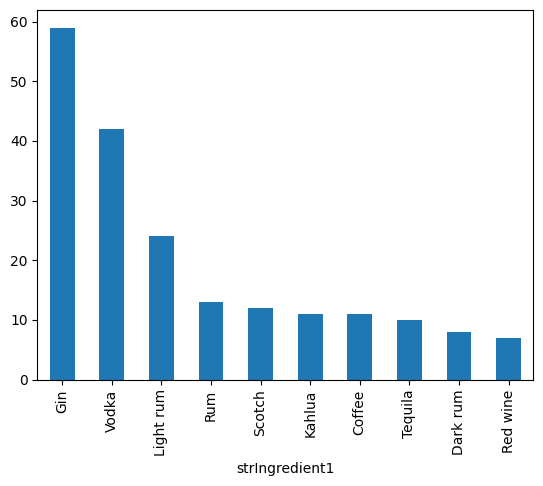

In [115]:
#
all_drinks_df['strIngredient1'].value_counts().head(10).plot.bar()

<Axes: xlabel='strCategory'>

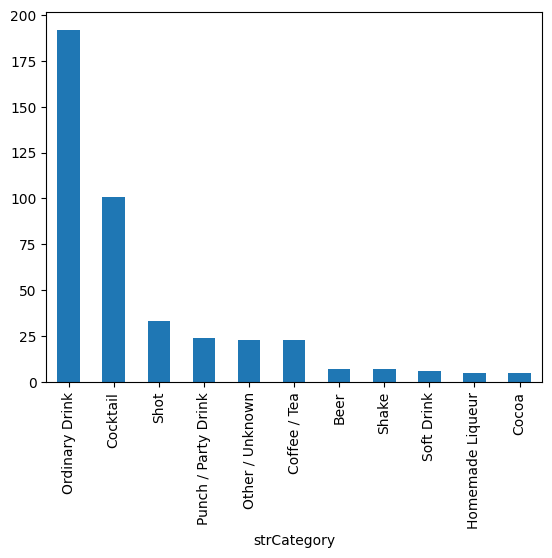

In [116]:
all_drinks_df['strCategory'].value_counts().plot.bar()

In [117]:
all_drinks_df[all_drinks_df['strCategory']== 'Ordinary Drink']['strMeasure2'].value_counts()

strMeasure2
0.500     44
1.000     39
0.750     23
1.500     12
2.000     11
0.300      8
3.000      7
0.170      7
0.250      4
4.000      4
5.000      3
1.330      3
0.670      3
0.510      3
12.000     2
8.000      1
0.083      1
9.000      1
16.000     1
1.350      1
1.700      1
2.500      1
6.000      1
0.330      1
0.041      1
0.040      1
0.020      1
5.410      1
Name: count, dtype: int64

<Axes: xlabel='strGlass'>

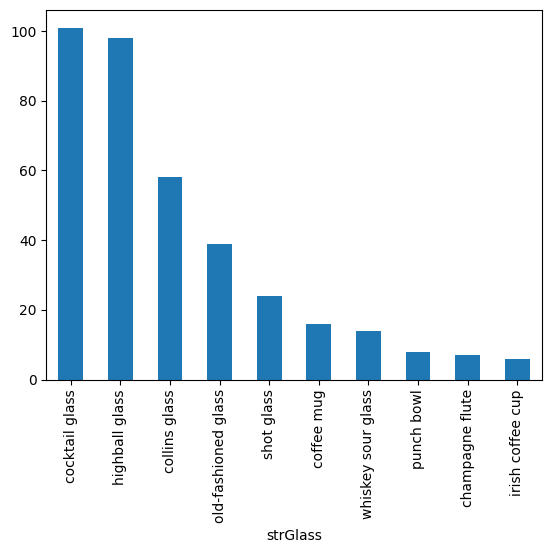

In [118]:
all_drinks_df['strGlass'].value_counts().head(10).plot.bar()

<Axes: xlabel='strIngredient1'>

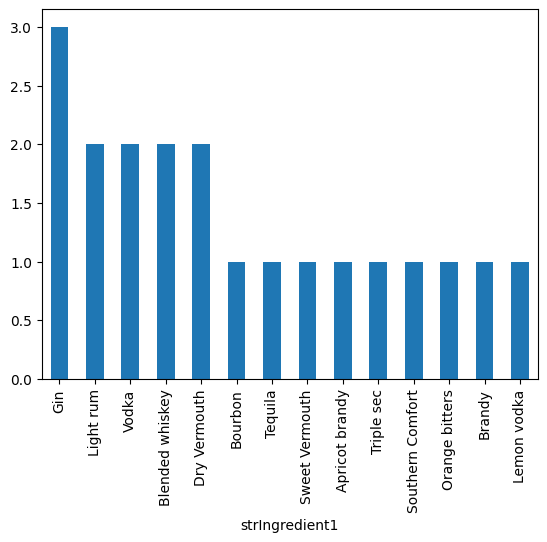

In [119]:
popular_drinks_df['strIngredient1'].value_counts().plot.bar()

<Axes: ylabel='count'>

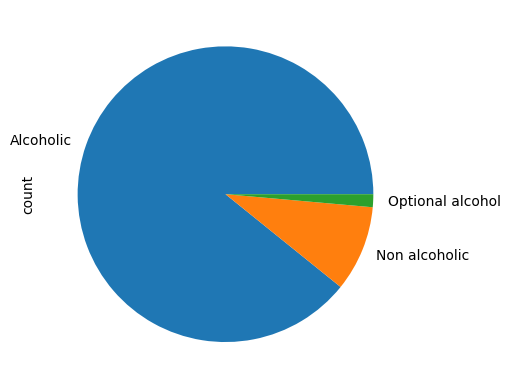

In [120]:
all_drinks_df['strAlcoholic'].value_counts().plot.pie()

# Data Visualization 

In [121]:
df['ingredients_combined']

0        gin, grand marnier, lemon juice, grenadine
1             amaretto, baileys irish cream, cognac
2      gin, grenadine, heavy cream, milk, egg white
3                            proof rum, wild turkey
4                  dark rum, lemon juice, grenadine
                           ...                     
421                zima, chambord raspberry liqueur
422              cointreau, lemon juice, ice, lemon
423                      midori melon liqueur, zima
424                          amaretto, rum, koolaid
425                           vermouth, apple juice
Name: ingredients_combined, Length: 426, dtype: object

In [122]:
df.columns

Index(['idDrink', 'strDrink', 'strTags', 'strCategory', 'strIBA',
       'strAlcoholic', 'strGlass', 'strInstructions', 'strIngredient1',
       'strIngredient2', 'strIngredient3', 'strIngredient4', 'strIngredient5',
       'strIngredient6', 'strIngredient7', 'strIngredient8', 'strIngredient9',
       'strIngredient10', 'strIngredient11', 'strMeasure1', 'strMeasure2',
       'strMeasure3', 'strMeasure4', 'strMeasure5', 'strMeasure6',
       'strMeasure7', 'strMeasure8', 'strMeasure9', 'strMeasure10',
       'strMeasure11', 'ingredients_combined'],
      dtype='object')

In [123]:
all_drinks_df['strGlass'].value_counts().head()

strGlass
cocktail glass         101
highball glass          98
collins glass           58
old-fashioned glass     39
shot glass              24
Name: count, dtype: int64

In [124]:
df['strIBA'].value_counts()

strIBA
Unforgettables           25
Contemporary Classics    22
New Era Drinks           14
Name: count, dtype: int64

In [125]:
all_drinks_df['strCategory'].value_counts().head()

strCategory
Ordinary Drink         192
Cocktail               101
Shot                    33
Punch / Party Drink     24
Other / Unknown         23
Name: count, dtype: int64

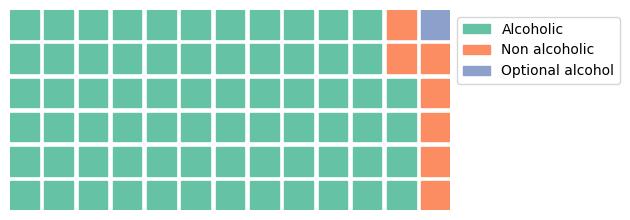

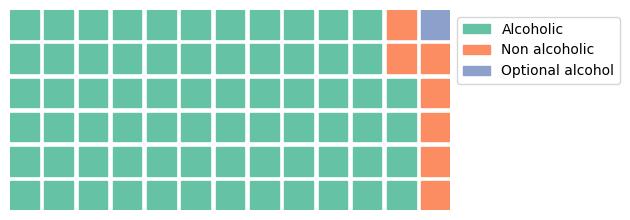

In [132]:
plt.figure(
    FigureClass=Waffle,
    rows=6,
    columns=13,
    values=df['strAlcoholic'].value_counts(),
    labels=['Alcoholic', 'Non alcoholic','Optional alcohol'],  # Legend would not be created without this line
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}
)